# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis. --- + 
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy` --- +)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`. --- +

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`. --- -
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. --- +`torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler). 
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset 
Use hold out validation scheme in your experiments.  --- +

1. You should use torchtext for parsing -- +

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






## Attention

* Работа не доделана! Я заболела, мне разрешили доделать после выздоровления. 
* На компьютере мало памяти, я работаю только с рандомновыбранной частью данных, поэтому при делении на тест и трейн я не принимаю во внимание уже существующее разделение.

## Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, RawField, BucketIterator, TabularDataset, Iterator

SEED = 42
np.random.seed(SEED)

In [2]:
from string import punctuation
from nltk.corpus import stopwords
import warnings
from tqdm import tqdm_notebook

warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("data.csv", sep=',', encoding = "ISO-8859-1")

In [6]:
df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [7]:
df.label.value_counts()

unsup    50000
pos      25000
neg      25000
Name: label, dtype: int64

In [3]:
from nltk.stem.wordnet import WordNetLemmatizer
morph = WordNetLemmatizer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('english'))

def normalize(text):
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.lemmatize(word) for word in words if word and word not in stops]
    return words #' '.join(words)

def tokenizer(text):
    words = [word.strip(punct) for word in text.lower().split()]
    return words


## torchtext

In [4]:
classes={
    'neg':0,
    'unsup':1,
    'pos':2
}

type_cl={
    'train':0,
    'test':1,
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=stops)
LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

#TYPE = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: type_cl[x])

dataset = TabularDataset('data2.csv', format='csv', 
                         fields=[(None, None), (None, None), ('review', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

#,type,review,label,file

In [5]:
#TEXT.build_vocab(dataset, min_freq=10, vectors="glove.6B.100d")
TEXT.build_vocab(dataset, max_size=25000, min_freq=20)
len(TEXT.vocab.itos)

1190

In [6]:
TEXT.vocab.itos[:10]

['<unk>', '<pad>', '<eos>', 'br', 'movie', 'film', 'one', 'like', '', 'bad']

In [7]:
LABEL.build_vocab(dataset)

In [8]:
train, test = dataset.split(0.7, stratified=True)#, strata_field='type')
train, valid = train.split(0.7, stratified=True)

#### Model

In [9]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, weights, froze=True, model2=False):
        super(MyModel, self).__init__()
        
        if model2 is True: # task 3
            self.embedding = tt.nn.Embedding(vocab_size, embed_size)
            tt.nn.init.uniform_(self.embedding.weight)
        else: # task 1 and 2
            self.embedding = nn.Embedding.from_pretrained(weights, freeze=froze)

        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1, 2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x


In [10]:
def build(n_epo, train, valid, test, weights, model2=False):
    
    global TEXT
    
    def fit(n_epo, train_iterator, optimizer, model, criterion, scheduler, valid_iterator):
        
        early = 0
        min_loss = float('inf')
        total_lr = []
        t_par = tqdm_notebook([_ for _ in range(n_epo)], desc='epoch', leave=True)
    
        for i in t_par:
            loss = 0
            model.train()

            for batch in train_iterator:
        
                optimizer.zero_grad()
                pred = model.forward(batch.review[0])
                loss = criterion(pred, batch.label)
                optimizer.step()
                loss += loss.item()
                loss.backward()
                
            total_lr.append(optimizer.param_groups[0]['lr'])
                
            loss = 0
            model.eval()
                
            with tt.no_grad():
    
                for batch in valid_iterator:
                    pred = model.forward(batch.review[0])
                    loss += criterion(pred, batch.label)
                    loss += loss.item()
        
                if loss < min_loss:
                    min_loss = loss
                    early = 0
                else:
                    early += 1
                if early > 10:
                    break
            scheduler.step(loss)

        return total_lr
    

    tt.cuda.empty_cache()
    batch_size = 32

    model = MyModel(len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=128,
                kernels=[2,3,4,5], weights=weights,
               model2=model2)
    print("model initialized")

    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train, valid, test),
        batch_sizes=(batch_size, batch_size, batch_size),
        shuffle=True,
        sort_key=lambda x: len(x.review))
    print("train_iterator, valid_iterator, test_iterator initialized")

    optimizer = optim.Adam(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
    criterion = tt.nn.CrossEntropyLoss()
    print('starting fitting')
    total_lr = fit(n_epo, train_iterator, optimizer, model, criterion, scheduler, valid_iterator)
    
    return model, test_iterator, total_lr

In [19]:
def predict(text, model):
    
    global TEXT
    
    if isinstance(text, str):
        tokenized = tokenizer(text)
        text = TEXT.preprocess(text)
        indexed = [[TEXT.vocab.stoi[t] for t in text]]
        text = tt.LongTensor(indexed)

    prediction = tt.sigmoid(model(text))
    return prediction

## Using pretrained word embeddings with frozen weights.

In [12]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('/Users/Stoneberry/Downloads/GoogleNews-vectors-negative300.bin', binary=True)  

In [13]:
weights = tt.FloatTensor(w2v_model.vectors)

In [14]:
weights.shape

torch.Size([3000000, 300])

In [15]:
model, test_iterator, total_lr = build(10, train, valid, test, weights, model2=False)

model initialized
train_iterator, valid_iterator, test_iterator initialized
starting fitting


Epoch     6: reducing learning rate of group 0 to 1.0000e-04.



In [16]:
import matplotlib.pyplot as plt

def my_plot(n_epo, total_loss):
    
    plt.plot([i for i in range(n_epo)], total_loss, )
    plt.show()


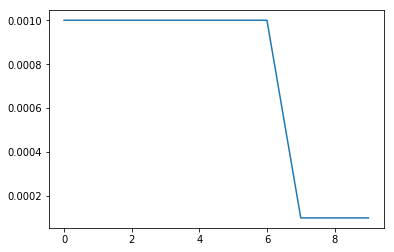

In [17]:
my_plot(10, total_lr)

Test

In [20]:
res = []
t_par = tqdm_notebook(test_iterator, desc='i', leave=True)

for i in t_par:
    pred = predict(i.review[0], model)
    res.append(pred)

## Train embeddings yourself, initializing from pretrained weights.

Обучаем w2v на данных с семинара

In [22]:
data = pd.read_csv('/Users/Stoneberry/Downloads/Tweets.csv')

In [23]:
documents = []

for line in data.text:
    documents.append(gensim.utils.simple_preprocess(line))

In [24]:
my_w2v = gensim.models.Word2Vec(
        documents,
        size=150,
        window=10,
        min_count=2,
        workers=10)
my_w2v.train(documents, total_examples=len(documents), epochs=10)

(1780038, 2441730)

In [25]:
my_weights = tt.FloatTensor(w2v_model.vectors)

In [26]:
my_weights.shape

torch.Size([3000000, 300])

Модель

In [27]:
model2, test_iterator2, total_lr2 = build(10, train, valid, test, my_weights, model2=False)

model initialized
train_iterator, valid_iterator, test_iterator initialized
starting fitting


Epoch     6: reducing learning rate of group 0 to 1.0000e-04.


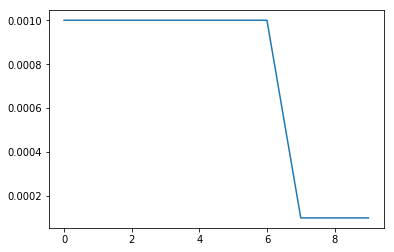

In [29]:
my_plot(10, total_lr2)

Predict

In [28]:
res2 = []
t_par = tqdm_notebook(test_iterator2, desc='i', leave=True)

for i in t_par:
    pred = predict(i.review[0], model2)
    res2.append(pred)

## Train embeddings yourself with random initialization 

torch.nn.init.uniform_(nn.Embeddings.weights)

In [30]:
model3, test_iterator3, total_lr3 = build(10, train, valid, test, my_weights, model2=True)

model initialized
train_iterator, valid_iterator, test_iterator initialized
starting fitting


Epoch     6: reducing learning rate of group 0 to 1.0000e-04.


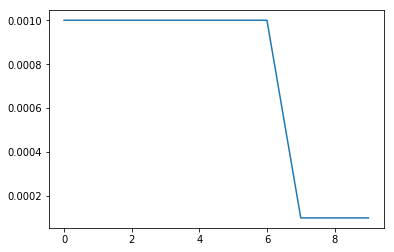

In [31]:
my_plot(10, total_lr3)

In [32]:
res3 = []
t_par = tqdm_notebook(test_iterator3, desc='i', leave=True)

for i in t_par:
    pred = predict(i.review[0], model3)
    res3.append(pred)